In [1]:
import math
from math import cos, sin, log, log10, pi
from decimal import Decimal as D
import numpy as np
from matplotlib import pyplot as plt
pi, math.e

(3.141592653589793, 2.718281828459045)

In [49]:
import time as tt
from datetime import datetime

def asHoursMins(s):
    h = math.floor(s / 3600)
    s -= h * 3600
    m = math.floor(s / 60)
    s -= m * 60
    return '%2dh %2dm %2ds' % (h, m, s)

# For the use of decorator, refer to the following two links:
#
# https://medium.com/citycoddee/python%E9%80%B2%E9%9A%8E%E6%8A%80%E5%B7%A7-3-%E7%A5%9E%E5%A5%87%E5%8F%88%E7%BE%8E%E5%A5%BD%E7%9A%84-decorator-%E5%97%B7%E5%97%9A-6559edc87bc0
# https://dev.to/apcelent/python-decorator-tutorial-with-example-529f

class code_timer:
    def __init__(self, func):
        self.code_func = func
        self.code_name = func.__name__
        
    def __call__(self, *args, **kwargs):
        start_time = datetime.fromtimestamp(tt.time())
        print('Begin running %s at %s ...'%\
              (self.code_name, start_time.strftime("%Y-%m-%d %H:%M:%S")))
        result = self.code_func(*args, **kwargs)
        stop_time = datetime.fromtimestamp(tt.time())
        train_time = (stop_time - start_time).total_seconds()
        print('Done running at %s!'%\
              (stop_time.strftime("%Y-%m-%d %H:%M:%S")))
        print('Total running time : %s'%(asHoursMins(train_time)))
        return result

### Check Two Particles in 3D Space with Sun and Earth Motion Data

In [3]:
# setting
mass_sun = 1.9891e30
mass_earth = mass_sun / 332946.
mass = (mass_sun * mass_earth) / (mass_sun + mass_earth)
G = 6.67384e-11
fac_GMm = G * mass_sun * mass_earth    # the factor for gravitational system of sun and earth
fac = fac_GMm


AU = 1.495978707e11
day = 60. * 60. * 24

T_max = 365. * day
dt = .001 * day
t = 0.0

# fac = 1  # the factor for testing circular motion
# mass = 1.
# T_max = 10.
# dt = 0.001
# t = 0.
decimal_place = [-1, -8]  # Define the range of decimal place

In [4]:
# The unit of velocity is AU / day
x, y, z = map(lambda x: x * AU, (1.160148e-1, -9.266055e-1, -4.018062e-1))
vx, vy, vz = map(lambda x: x * AU / day, (1.681162e-2, 1.743130e-3, 7.599750e-4))  
earth_x = (x, y, z)
earth_v = (vx, vy, vz)

In [5]:
# Consider gravitation and in 3D space
# The force to object 1 from object 2 according to center of mass frame

def force(x1, y1, z1, x2, y2, z2, m1, m2):
    fac = G * m1 * m2
    x, y, z = (x1 - x2, y1 - y2, z1 - z2)
    r = (x * x + y * y + z * z)**0.5
    f = -1 * fac / (r**3)
    fx = f * x
    fy = f * y
    fz = f * z
    return fx, fy, fz

In [52]:
# Gravitational potential in 3D space
def potential(x=1., y=0., z=0.):
    r = (x * x + y * y + z * z)**0.5
    p = -1 * fac / r
    return p

In [53]:
# Kinetic energy in 3D space
def kinetic_energy(m=0., vx=0., vy=0., vz=0.):
    k = 0.5 * m * (vx * vx + vy * vy + vz * vz)
    return k

In [8]:
def varlet_velocity_2P_3D(t=0.0,\
                          x1=1.0, y1=0.0, z1=0.0,\
                          vx1=0.0, vy1=0.0, vz1=0.0,\
                          x2=1.0, y2=0.0, z2=0.0,\
                          vx2=0.0, vy2=0.0, vz2=0.0,\
                          dt=0.001, t_final=T_max,\
                          m1=mass_earth, m2=mass_sun, force=force):
    # Must ensure it can run single step calculation.
    # That is, when t = t_0, t_final = t_0 + dt, the result must be correct.
    
    x1_lst = []
    v1_lst = []
    x1_lst.append((x1, y1 ,z1))
    v1_lst.append((vx1, vy1, vz1))
    
    x2_lst = []
    v2_lst = []
    x2_lst.append((x2, y2 ,z2))
    v2_lst.append((vx2, vy2, vz2))
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    # Warning 1: never use np.arange to iterate over float steps
    # because sometimes it will abnormaly include stop condition,
    # which is the result that we do not want it happen.
    #
    # Warning 2: even if you add step size to time iteratively,
    # there is still an inherent error, i.e. floating-point approximation
    # error, which is due to the non-exact representation from
    # the binary floating point standard(IEEE-754). The workaround
    # is to use the decimal.Decimal(str(float_number)) in iteration.
    
    while (time < t_final):
        time += dt_t
        
        fx1, fy1, fz1 = force(x1, y1, z1, x2, y2, z2, m1, m2)
        vx1, vy1, vz1 = map(lambda f, v : v + f / (2 * m1) * dt, (fx1, fy1, fz1), (vx1, vy1, vz1))
        fx2, fy2, fz2 = force(x2, y2, z2, x1, y1, z1, m2, m1)
        vx2, vy2, vz2 = map(lambda f, v : v + f / (2 * m2) * dt, (fx2, fy2, fz2), (vx2, vy2, vz2))
        
        x1, y1, z1 = map(lambda x, v : x + v * dt, (x1, y1, z1), (vx1, vy1, vz1))
        x2, y2, z2 = map(lambda x, v : x + v * dt, (x2, y2, z2), (vx2, vy2, vz2))
        
        fx1, fy1, fz1 = force(x1, y1, z1, x2, y2, z2, m1, m2)
        vx1, vy1, vz1 = map(lambda f, v : v + f / (2 * m1) * dt, (fx1, fy1, fz1), (vx1, vy1, vz1))
        fx2, fy2, fz2 = force(x2, y2, z2, x1, y1, z1, m2, m1)
        vx2, vy2, vz2 = map(lambda f, v : v + f / (2 * m2) * dt, (fx2, fy2, fz2), (vx2, vy2, vz2))
        
#         print(dt, (x, y, z), (vx, vy, vz))
        x1_lst.append((x1, y1, z1))
        v1_lst.append((vx1, vy1, vz1))
        
        x2_lst.append((x2, y2, z2))
        v2_lst.append((vx2, vy2, vz2))
        
    return x1_lst, v1_lst, x2_lst, v2_lst

In [9]:
x1_lst, v1_lst, x2_lst, v2_lst = varlet_velocity_2P_3D(x1=earth_x[0], y1=earth_x[1], z1=earth_x[2],\
                                     vx1=earth_v[0], vy1=earth_v[1], vz1=earth_v[2],\
                                     x2=0., y2=0., z2=0.,\
                                     vx2=0., vy2=0., vz2=0.,\
                                     m1=mass_earth, m2=mass_sun,\
                                     dt=dt, force=force)
len(x1_lst)

365001

In [12]:
x_earth, y_earth, z_earth = zip(*x1_lst)
# vx_earth, vy_earth, vz_earth = zip(*v1_lst)
x_earth, y_earth, z_earth = map(lambda a: [i / AU for i in a], (x_earth, y_earth, z_earth))

In [13]:
len(x_earth), len(y_earth), len(z_earth)

(365001, 365001, 365001)

In [14]:
x_sun, y_sun, z_sun = zip(*x2_lst)
# vx_sun, vy_sun, vz_sun = zip(*v2_lst)
x_sun, y_sun, z_sun = map(lambda a: [i / AU for i in a], (x_sun, y_sun, z_sun))

In [15]:
len(x_sun), len(y_sun), len(z_sun)

(365001, 365001, 365001)

In [17]:
x_all = zip(x_earth, x_sun)
y_all = zip(y_earth, y_sun)
z_all = zip(z_earth, z_sun)

x_, y_, z_ = map(lambda a: [i[0] - i[1] for i in a], (x_all, y_all, z_all)) 
len(x_)

365001

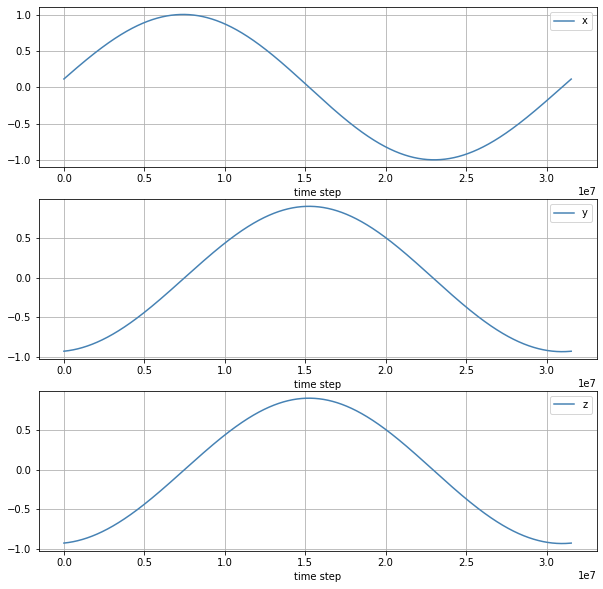

In [38]:
fig, ax1 = plt.subplots(3, 1, figsize=(10, 10))
ax1[0].set_xlabel('time step')
ax1[1].set_xlabel('time step')
ax1[2].set_xlabel('time step')
# ax1.set_ylabel('position', color='b')
x__, = ax1[0].plot(np.arange(0.0, T_max, dt), x_[:-1], label='x', color='steelblue')
# x_e, = ax1[0][1].plot(np.arange(0.0, T_max, dt), x_exact[:-1], label='x (exact)', color='maroon')
y__, = ax1[1].plot(np.arange(0.0, T_max, dt), y_[:-1], label='y', color='steelblue')
# y_e, = ax1[1][1].plot(np.arange(0.0, T_max, dt), y_exact[:-1], label='y (exact)', color='maroon')
z__, = ax1[2].plot(np.arange(0.0, T_max, dt), y_[:-1], label='z', color='steelblue')

# ax1[0][0].tick_params(axis='y', labelcolor='steelblue')
# ax1[0][1].tick_params(axis='y', labelcolor='maroon')
# ax1[1][0].tick_params(axis='y', labelcolor='steelblue')
# ax1[1][1].tick_params(axis='y', labelcolor='maroon')

# ax2 = ax1[0][0].twinx()
# vel, = ax2.plot(np.arange(0.0, T_max, dt), vx_[:-1], label='velocity', color='darkorange')
# ax2.tick_params(axis='y', labelcolor='darkorange')
ax1[0].legend()
ax1[1].legend()
ax1[2].legend()
ax1[0].grid(axis='both')
ax1[1].grid(axis='both')
ax1[2].grid(axis='both')

# plt.legend(handles=[pos, vel])
# plt.grid(axis='both')
plt.savefig('xv.png')
plt.show()

### Calculate If Period of Earth Rotation Around Sun Is Equal to 365 

In [45]:
@code_timer
def calculate_period_2P(t=0.0, x1=2.0, v1=0.0, x2=0.0, v2=0.0,\
                        dt=0.001, t_final=T_max, m1=mass_earth, m2=mass_sun, force=force):
    x0 = x1    # initial position of object 1 
    dot_product_max = 0.
    
    begin_time = 0
    end_time = 0
    counter = 0
    period = 0
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x1_old, v1_old, x2_old, v2_old = x1, v1, x2, v2
        x1_l, v1_l, x2_l, v2_l = varlet_velocity_2P_3D(t=time,\
                                         x1=x1_old[0], y1=x1_old[1], z1=x1_old[2],\
                                         vx1=v1_old[0], vy1=v1_old[1], vz1=v1_old[2],\
                                         x2=x2_old[0], y2=x2_old[1], z2=x2_old[2],\
                                         vx2=v2_old[0], vy2=v2_old[1], vz2=v2_old[2],\
                                         m1=mass_earth, m2=mass_sun,\
                                         t_final=time+dt_t,\
                                         dt=dt, force=force)
        
        x1, v1, x2, v2 = x1_l[-1], v1_l[-1], x2_l[-1], v2_l[-1]
        x = [a - b for (a, b) in zip(x1, x2)]
        
        time += dt_t
        if (float(time) / day) > 350:
            dot_product = x0[0] * x[0] + x0[1] * x[1] + x0[2] * x[2]
            if dot_product >= dot_product_max:
                dot_product_max = dot_product
                end_time = time
        
    period = float(end_time - begin_time) / day
    return period

In [50]:
mass_earth_period = calculate_period_2P(x1=earth_x, v1=earth_v,\
                                        x2=(0.,0.,0.), v2=(0.,0.,0.), dt=dt, t_final=1.1*T_max,\
                                        m1=mass_earth, m2=mass_sun)

Begin running calculate_period_2P at 2020-12-21 11:39:51 ...
Done running at 2020-12-21 11:39:54!
Total running time :  0h  0m  3s


In [51]:
mass_earth_period

365.172

### Check Energy Conservation Error in 3D Space and Plot

In [64]:
def energy_conservation(t=0.0, x1=2.0, v1=0.0, x2=0.0, v2=0.0,\
                        dt=0.001, t_final=T_max, m1=mass_earth, m2=mass_sun, force=force):
    x0 = x1    # initial position of object 1 
    
    energy_list = []
    
    ENERGY = potential(x=x0[0], y=x0[1], z=x0[2]) + \
             kinetic_energy(m=m1, vx=v1[0], vy=v1[1], vz=v1[2])
    
    energy_list.append(ENERGY)
    
    time = D(str(t))
    t_final = D(str(t_final))
    dt_t = D(str(dt))
    
    while (time < t_final):
        x1_old, v1_old, x2_old, v2_old = x1, v1, x2, v2
        x1_l, v1_l, x2_l, v2_l = varlet_velocity_2P_3D(t=time,\
                                         x1=x1_old[0], y1=x1_old[1], z1=x1_old[2],\
                                         vx1=v1_old[0], vy1=v1_old[1], vz1=v1_old[2],\
                                         x2=x2_old[0], y2=x2_old[1], z2=x2_old[2],\
                                         vx2=v2_old[0], vy2=v2_old[1], vz2=v2_old[2],\
                                         m1=mass_earth, m2=mass_sun,\
                                         t_final=time+dt_t,\
                                         dt=dt, force=force)
        
        x1, v1, x2, v2 = x1_l[-1], v1_l[-1], x2_l[-1], v2_l[-1]
        x = [a - b for (a, b) in zip(x1, x2)]
        
        energy = potential(x=x[0], y=x[1], z=x[2]) +\
                 kinetic_energy(m=m1, vx=v1[0], vy=v1[1], vz=v1[2]) +\
                 kinetic_energy(m=m2, vx=v2[0], vy=v2[1], vz=v2[2])
        energy_list.append(energy)
        
        time += dt_t
        if (float(time) / day) > 0.2:
            break
        
    return energy_list

In [55]:
e_list = energy_conservation(x1=earth_x, v1=earth_v,\
                             x2=(0.,0.,0.), v2=(0.,0.,0.), dt=dt, t_final=1.1*T_max,\
                             m1=mass_earth, m2=mass_sun)

In [56]:
len(e_list)

502

In [66]:
e_list

[-2.6513483381956667e+33,
 -2.6513483381956655e+33,
 -2.6513483381956667e+33,
 -2.6513483381956655e+33,
 -2.651348338195666e+33,
 -2.651348338195665e+33,
 -2.6513483381956667e+33,
 -2.6513483381956655e+33,
 -2.651348338195665e+33,
 -2.6513483381956667e+33,
 -2.651348338195666e+33,
 -2.6513483381956667e+33,
 -2.651348338195666e+33,
 -2.651348338195666e+33,
 -2.6513483381956667e+33,
 -2.6513483381956655e+33,
 -2.6513483381956655e+33,
 -2.651348338195668e+33,
 -2.651348338195668e+33,
 -2.6513483381956667e+33,
 -2.6513483381956684e+33,
 -2.651348338195668e+33,
 -2.651348338195667e+33,
 -2.651348338195667e+33,
 -2.6513483381956684e+33,
 -2.6513483381956684e+33,
 -2.6513483381956684e+33,
 -2.651348338195669e+33,
 -2.651348338195669e+33,
 -2.651348338195668e+33,
 -2.6513483381956684e+33,
 -2.6513483381956684e+33,
 -2.6513483381956696e+33,
 -2.651348338195669e+33,
 -2.651348338195669e+33,
 -2.651348338195669e+33,
 -2.651348338195668e+33,
 -2.6513483381956684e+33,
 -2.651348338195668e+33,
 -2.6

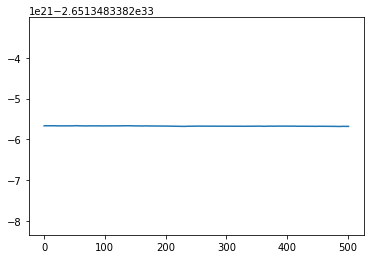

In [57]:
plt.plot(e_list)
plt.show()

In [62]:
@code_timer
def compute_3D_energy_error(init_time=0.0, x1=earth_x, v1=earth_v,\
                            x2=(0.,0.,0.), v2=(0.,0.,0.), dt=dt, t_final=1.1*T_max,\
                            m1=mass_earth, m2=mass_sun):
    exponent = list(range(decimal_place[0], decimal_place[1], -1))
    energy_error_list = []
    
    x0 = x1
    ENERGY = potential(x=x0[0], y=x0[1], z=x0[2]) + \
             kinetic_energy(m=m1, vx=v1[0], vy=v1[1], vz=v1[2])
#     print(x_e)
    
    for _ in exponent:
        dt = 10**(_)
        e_list = energy_conservation(x1=x1, v1=v1,\
                                     x2=x2, v2=v2, dt=dt,\
                                     m1=mass_earth, m2=mass_sun)
        energy_err = abs((e_list[-1] - ENERGY) / ENERGY)
        print(dt, energy_err)
        energy_error_list.append(energy_err)
    return energy_error_list

In [65]:
x_error = compute_3D_energy_error()
x_error

Begin running compute_3D_energy_error at 2020-12-21 12:46:27 ...
0.1 1.1088508418128854e-14
0.01 7.827182412796838e-15
0.001 5.0659263949490646e-14


KeyboardInterrupt: 

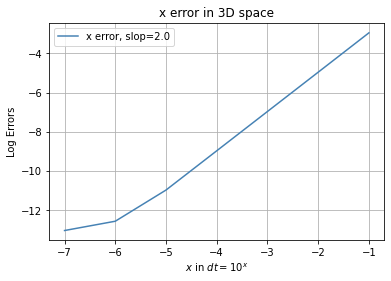

In [83]:
def get_slop(err_list):
    x_big = -1
    x_small = 0 - len(err_list) + 2
    slop = (err_list[x_big] - err_list[x_small]) / (x_big - x_small)
    return slop

new_e = list(range(decimal_place[0], decimal_place[1], -1))[::-1]
new_x_error = [log10(_) for _ in x_error[::-1]]
slop = get_slop(new_x_error)

color_list = ['', 'maroon', 'orange', 'lightgreen', 'steelblue', 'darkorchid']

x_error_h, = plt.plot(new_e, new_x_error, color=color_list[4], label=r'x error, slop=%1.1f'%slop)
plt.legend(handles=[x_error_h])
plt.title(r'x error in 3D space')
plt.xlabel(r'$x$ in $dt=10^{x}$')
plt.ylabel('Log Errors')
plt.grid()
plt.savefig('delta_x_error.png')
plt.show()
plt.close()